In [18]:
import os
import gc
import numpy as np

from scipy.optimize import curve_fit
from obspy import UTCDateTime
from pandas import DataFrame, date_range

import matplotlib.pyplot as plt

from andbro__read_sds import __read_sds

In [2]:
import sys
sys.path.append('../')

In [55]:
from functions.load_mlti import __load_mlti
from functions.reduce import __reduce
from functions.smoothing import __smooth
from functions.get_mlti_intervals import __get_mlti_intervals
from functions.mlti_intervals_to_NaN import __mlti_intervals_to_NaN
from functions.load_beam_wander_data import __load_beam_wander_data

In [4]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/ontap-ffb-bay200/'
    lamont_path = '/home/andbro/lamont/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'

## Configurations

In [5]:
config = {}

config['path_to_data'] = data_path+f"ids/"

config['path_to_outdata'] = data_path+"ids/data/"

config['path_to_figures'] = data_path+"ids/figures/"

# temperature anomaly
config['date1'] = "2024-05-24"
config['date2'] = "2024-06-24"

config['cut_time'] = None

# conversion from pixel to mm
config['conversion'] = {"XX":1.67e-3,
                        "01":5.3e-3,
                        "03":5.3e-3,
                        "07":5.3e-3,
                       }


### Load MLTI Log

In [6]:
mltiU = __load_mlti(config['date1'], config['date2'], "U", archive_path)
mltiU_t1, mltiU_t2 = __get_mlti_intervals(mltiU.time_utc)

mltiZ = __load_mlti(config['date1'], config['date2'], "Z", archive_path)
mltiZ_t1, mltiZ_t2 = __get_mlti_intervals(mltiZ.time_utc)

mltiV = __load_mlti(config['date1'], config['date2'], "V", archive_path)
mltiV_t1, mltiV_t2 = __get_mlti_intervals(mltiV.time_utc)


### Load Maintenance Log

In [15]:
from functions.load_lxx import __load_lxx
from functions.get_lxx_intervals import __get_lxx_intervals

lxx =__load_lxx(config['date1'], config['date2'], archive_path)
lxx_t1, lxx_t2 = __get_lxx_intervals(lxx.datetime)


### Load Beam Wander Data

In [49]:
df0 = __load_beam_wander_data(config['date1'], config['date2'], config['path_to_data'], "")

2024-05-24
2024-05-25
2024-05-26
2024-05-27
2024-05-28
2024-05-29
2024-05-30
2024-05-31
2024-06-01
2024-06-02
2024-06-03
2024-06-04
2024-06-05
2024-06-06
2024-06-07
2024-06-08
2024-06-09
2024-06-10
2024-06-11
2024-06-12
 -> error for 20240612.pkl
2024-06-13
2024-06-14
2024-06-15
2024-06-16
2024-06-17
2024-06-18
2024-06-19
2024-06-20
2024-06-21
2024-06-22
2024-06-23
 -> error for 20240623.pkl
2024-06-24


In [8]:
df3 = __load_beam_wander_data(config['date1'], config['date2'], config['path_to_data'], "03")

2024-05-24
2024-05-25
2024-05-26
2024-05-27
2024-05-28
2024-05-29
2024-05-30
2024-05-31
2024-06-01
2024-06-02
2024-06-03
2024-06-04
2024-06-05
2024-06-06
2024-06-07
2024-06-08
2024-06-09
2024-06-10
2024-06-11
2024-06-12
2024-06-13
2024-06-14
2024-06-15
2024-06-16
2024-06-17
2024-06-18
2024-06-19
2024-06-20
2024-06-21
2024-06-22
2024-06-23
2024-06-24


In [9]:
df7 = __load_beam_wander_data(config['date1'], config['date2'], config['path_to_data'], "07")

2024-05-24
2024-05-25
2024-05-26
2024-05-27
2024-05-28
2024-05-29
2024-05-30
2024-05-31
2024-06-01
2024-06-02
2024-06-03
2024-06-04
2024-06-05
2024-06-06
2024-06-07
2024-06-08
2024-06-09
2024-06-10
2024-06-11
2024-06-12
2024-06-13
2024-06-14
2024-06-15
2024-06-16
2024-06-17
2024-06-18
2024-06-19
2024-06-20
2024-06-21
2024-06-22
2024-06-23
2024-06-24


### Pre-Processing

In [10]:
def __pre_process(df0, mlti_t1, mlti_t2, conversion_factor):

    from functions.reduce import __reduce

    # add utc object
    df0['time_utc'] = [UTCDateTime(tl) for tl in df0.time]

    keys_to_convert = ["y_idx", "x_idx", "y", "x", "x_sig", "y_sig", "y_var", "x_var"]

    # from pixel to mm
    for k in keys_to_convert:
        df0[k] *= conversion_factor

    # turn times with MLTI to NaN
    df0 = __mlti_intervals_to_NaN(df0, "y_idx", "time_utc", mlti_t1, mlti_t2, t_offset_sec=180)
    df0 = __mlti_intervals_to_NaN(df0, "x_idx", "time_utc", mlti_t1, mlti_t2, t_offset_sec=180)

    # remove bad estimates
    df0 = df0[df0['y_sig_var'] != np.inf]
    df0 = df0[df0['x_sig_var'] != np.inf]

    # when intensity is super low, there is a black image
    df0 = df0[df0['amp'] > 10]

    # when intensity is super high or saturated, there is likely a MLTI boost
    df0 = df0[df0['amp'] < 255]

    # to micrometer and relative to start
    df0['x_um_rel'] = __reduce(df0.x, 10) * 1e3
    df0['y_um_rel'] = __reduce(df0.y, 10) * 1e3

    df0['x_um_sig'] = df0.x_sig * 1e3
    df0['y_um_sig'] = df0.y_sig * 1e3

    df0['x_um_var'] = df0.x_var * 1e3
    df0['y_um_var'] = df0.y_var * 1e3

    # df0['x_um_sig'] = __reduce(df0.x_sig, 10) * 1e3
    # df0['y_um_sig'] = __reduce(df0.y_sig, 10) * 1e3

    df0.reset_index(inplace=True)

    return df0

In [50]:
df0 = __pre_process(df0, mltiU_t1, mltiU_t2, config['conversion']["XX"])

In [12]:
df7 = __pre_process(df7, mltiV_t1, mltiV_t2, config['conversion']["07"])

In [13]:
df3 = __pre_process(df3, mltiZ_t1, mltiZ_t2, config['conversion']["03"])

### Load Temperature Data

In [70]:
_ps1 = __read_sds(archive_path+"temp_archive/", "BW.PROMY.01.LKI", config['date1'], config['date2'])
_ps5 = __read_sds(archive_path+"temp_archive/", "BW.PROMY.05.LKI", config['date1'], config['date2'])
_ps7 = __read_sds(archive_path+"temp_archive/", "BW.PROMY.07.LKI", config['date1'], config['date2'])
_ps9 = __read_sds(archive_path+"temp_archive/", "BW.PROMY.09.LKI", config['date1'], config['date2'])

In [100]:
t1_temp, t2_temp = UTCDateTime("2024-06-17 10:00"), UTCDateTime("2024-06-21 12:00")

### Plotting

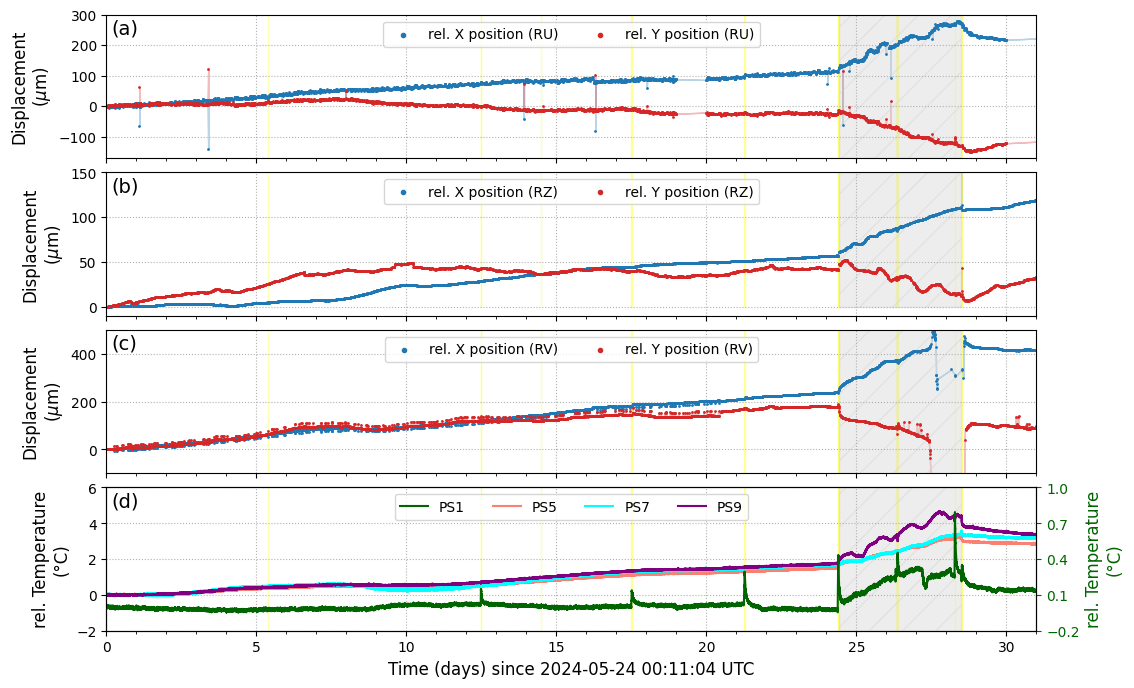

In [101]:
def __makeplot_overview():

    from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

    Nrow, Ncol = 4, 1

    font = 12
    
    size = 1
    
    tscale = 1/86400
    
    sig_scale = 3/2

    reftime = UTCDateTime(df0.time.iloc[0])
    
    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 8), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    for n, (_df, ring) in enumerate(zip([df0, df3, df7], ["RU", "RZ", "RV"])):

        ax[n].fill_between(_df.time_sec*tscale,
                           _df.x_um_rel-np.sqrt(_df.x_um_var)*sig_scale,
                           _df.x_um_rel+np.sqrt(_df.x_um_var)*sig_scale,
                           color="tab:blue", alpha=0.3, interpolate=False
                          )
        ax[n].scatter(_df.time_sec*tscale, _df.x_um_rel, s=size, zorder=2, color="tab:blue", label=f"rel. X position ({ring})")

        ax[n].fill_between(_df.time_sec*tscale,
                           _df.y_um_rel-np.sqrt(_df.y_um_var)*sig_scale,
                           _df.y_um_rel+np.sqrt(_df.y_um_var)*sig_scale,
                           color="tab:red", alpha=0.3, interpolate=False
                          )
        ax[n].scatter(_df.time_sec*tscale, _df.y_um_rel, s=size, zorder=2, color="tab:red", label=f"rel. Y position ({ring})")
        # ax[n].set_ylim(1.58, 1.69)
        ax[n].set_ylabel(f"Displacement\n($\mu$m)", fontsize=font)

        ax[n].legend(loc=9, ncol=2, markerscale=3)

        y_min, y_max = min([_df.x_um_rel.min(), _df.y_um_rel.min()]), max([_df.x_um_rel.max(), _df.y_um_rel.max()])
        ax[n].set_ylim(y_min*1.2, y_max*1.2)

    # __________________________________________
    ax[3].plot(_ps1[0].times(reftime=reftime)*tscale, __reduce(_ps1[0].data, 10)*np.nan,
               color="darkgreen", label="PS1"
              )
    ax[3].plot(_ps5[0].times(reftime=reftime)*tscale, __reduce(_ps5[0].data, 10),
               color="salmon", label="PS5"
              )
    ax[3].plot(_ps7[0].times(reftime=reftime)*tscale, __reduce(_ps7[0].data, 10),
               color="cyan", label="PS7"
              )
    ax[3].plot(_ps9[0].times(reftime=reftime)*tscale, __reduce(_ps9[0].data, 10),
               color="purple", label="PS9"
              )
    ax[3].set_ylabel(f"rel. Temperature\n(°C)", fontsize=font)
    ax[3].legend(loc=9, ncol=4)
    ax[3].set_ylim(-0.5, 5)

    ax333 = ax[3].twinx()
    ax333.plot(_ps1[0].times(reftime=reftime)*tscale, __smooth(__reduce(_ps1[0].data, 10), 60),
               color="darkgreen", label="PS1"
              )
    ax333.set_ylabel(f"rel. Temperature\n(°C)", fontsize=font, color="darkgreen")
    ax333.tick_params(axis='y', colors="darkgreen")
    ax[3].set_yticks(np.linspace(ax[3].get_yticks()[0], ax[3].get_yticks()[-1], len(ax[3].get_yticks())))
    ax333.set_yticks(np.linspace(ax333.get_yticks()[0], ax333.get_yticks()[-1], len(ax[3].get_yticks())))

    # add labels
    for _k, ll in enumerate(['(a)', '(b)', '(c)', '(d)']):
        ax[_k].text(.005, .97, ll, ha='left', va='top', transform=ax[_k].transAxes, fontsize=font+2)
        ax[_k].set_xlim(0, 31*86400*tscale)
        ax[_k].xaxis.set_major_locator(MultipleLocator(5))
        ax[_k].xaxis.set_minor_locator(MultipleLocator(1))

    ax[Nrow-1].set_xlabel(f"Time (days) since {reftime.date} {reftime.time} UTC", fontsize=font)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        _, _, _ymin, _ymax = ax[_n].axis()

        # add maintencane periods
        ref_date = config['date1']
        for lx1, lx2 in zip(lxx_t1, lxx_t2):
            lx1_sec = lx1-UTCDateTime(ref_date)
            lx2_sec = lx2-UTCDateTime(ref_date)
            ax[_n].fill_betweenx([_ymin, _ymax], lx1_sec*tscale, lx2_sec*tscale,
                                 color="yellow", alpha=0.3)

        # add temperature distortion
        ax[_n].fill_betweenx([_ymin, _ymax], (t1_temp-reftime)*tscale, (t2_temp-reftime)*tscale,
                             color="lightgrey", alpha=0.4, hatch="/")
    
    
    ax[0].set_ylim(-170, 300)
    ax[1].set_ylim(-10, 150)
    ax[2].set_ylim(-100, 500)

    plt.show();
    return fig

fig = __makeplot_overview();

fig.savefig(config['path_to_figures']+f"BW_temperture_{config['date1']}_{config['date2']}.png", format="png", dpi=150, bbox_inches='tight')


In [203]:
from functions.regression import __regression

In [204]:
def __get_dataframe(N1, N2):

    time = _ps9[0].times(reftime=df0.time_utc.iloc[0])
    temp = __reduce(_ps9[0].data, 10)

    dfz = DataFrame()
    dfz['temp'] = __reduce(np.interp(df3.time_sec, time, temp)[N1:N2], 10)
    dfz['x'] = __reduce(df3.x_um_rel[N1:N2].values, 10)
    dfz['time'] = df3.time_sec[N1:N2].values

    dfu = DataFrame()
    dfu['temp'] = __reduce(np.interp(df0.time_sec, time, temp)[N1:N2], 10)
    dfu['x'] = __reduce(df0.x_um_rel[N1:N2].values, 10)
    dfu['time'] = df0.time_sec[N1:N2].values

    dfv = DataFrame()
    dfv['temp'] = __reduce(np.interp(df7.time_sec, time, temp)[N1:N2], 10)
    dfv['x'] = __reduce(df7.x_um_rel[N1:N2].values, 10)
    dfv['time'] = df7.time_sec[N1:N2].values
    
    return dfz, dfu, dfv

dfz, dfu, dfv = __get_dataframe(0, 3000)

R2: 0.9266663415637747
X0: 0.3480743378593143
Coef:  [33.59998267]
temp : 33.599982665490494
R2: 0.8275741048957479
X0: 9.652498214655845
Coef:  [67.01856597]
temp : 67.01856597203074
R2: 0.9803132020442537
X0: 9.225731762623319
Coef:  [135.50563805]
temp : 135.50563805041963
R2: 0.9708535567787503
X0: 1.8562721761337138
Coef:  [17.65532565]
temp : 17.655325651681995
R2: 0.8911771531028061
X0: 1.7088315836032222
Coef:  [62.7088438]
temp : 62.70884380015462
R2: 0.9487247290149922
X0: 4.298907276289735
Coef:  [118.00915958]
temp : 118.00915958321764


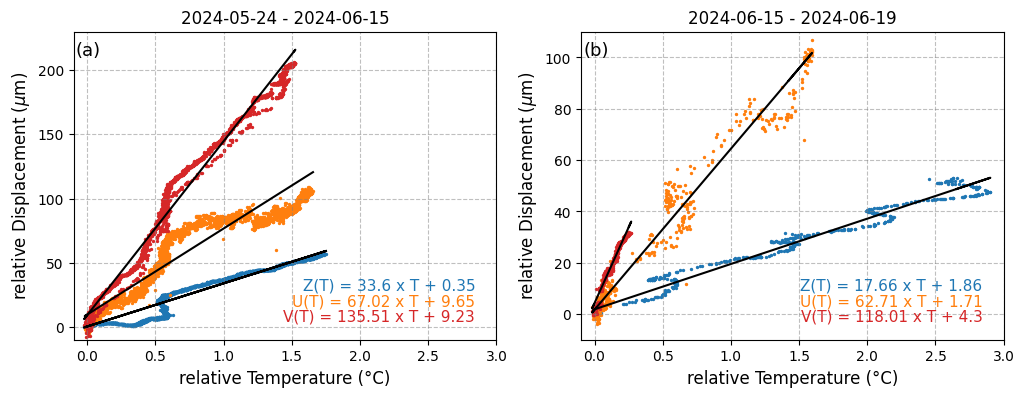

In [238]:
def __makeplot():

    import matplotlib.pyplot as plt

    reg="theilsen"
    
    
    # data before event
    t11, t12 = UTCDateTime(df0.time.iloc[0]).date, UTCDateTime(df0.time.iloc[3000]).date

    dfz1, dfu1, dfv1 = __get_dataframe(0, 3000)
    
    outz1 = __regression(dfz1, ["temp"], target="x", reg=reg)
    outu1 = __regression(dfu1, ["temp"], target="x", reg=reg)
    outv1 = __regression(dfv1, ["temp"], target="x", reg=reg)

    # data before event
    t21, t22 = UTCDateTime(df0.time.iloc[3000]).date, UTCDateTime(df0.time.iloc[3500]).date

    dfz2, dfu2, dfv2 = __get_dataframe(3000, 3500)
    
    outz2 = __regression(dfz2, ["temp"], target="x", reg=reg)
    outu2 = __regression(dfu2, ["temp"], target="x", reg=reg)
    outv2 = __regression(dfv2, ["temp"], target="x", reg=reg)

    Nrow, Ncol = 1, 2

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 4), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    ax[0].scatter(dfz1['temp'], dfz1['x'], s=2, label="Z", color="tab:blue")
    ax[0].plot(dfz1['temp'], outz1['slope']*dfz1['temp']+ outz1['inter'], "k")

    ax[0].scatter(dfu1['temp'], dfu1['x'], s=2, label="U", color="tab:orange")
    ax[0].plot(dfu1['temp'], outu1['slope']*dfu1['temp']+ outu1['inter'], "k")

    ax[0].scatter(dfv1['temp'], dfv1['x'], s=2, label="V", color="tab:red")
    ax[0].plot(dfv1['temp'], outv1['slope']*dfv1['temp']+ outv1['inter'], "k")

    ax[1].scatter(dfz2['temp'], dfz2['x'], s=2, label="Z", color="tab:blue")
    ax[1].plot(dfz2['temp'], outz2['slope']*dfz2['temp']+ outz2['inter'], "k")
    
    ax[1].scatter(dfu2['temp'], dfu2['x'], s=2, label="U", color="tab:orange")
    ax[1].plot(dfu2['temp'], outu2['slope']*dfu2['temp']+ outu2['inter'], "k")
    
    ax[1].scatter(dfv2['temp'], dfv2['x'], s=2, label="V", color="tab:red")
    ax[1].plot(dfv2['temp'], outv2['slope']*dfv2['temp']+ outv2['inter'], "k")
        

    lbl = f"Z(T) = {round(outz1['slope'][0], 2)} x T + {round(outz1['inter'], 2)}"
    ax[0].text(0.95, 0.2, lbl, ha="right", va="top", transform=ax[0].transAxes, fontsize=font-1, color="tab:blue")
    lbl = f"U(T) = {round(outu1['slope'][0], 2)} x T + {round(outu1['inter'], 2)}"
    ax[0].text(0.95, 0.15, lbl, ha="right", va="top", transform=ax[0].transAxes, fontsize=font-1, color="tab:orange")
    lbl = f"V(T) = {round(outv1['slope'][0], 2)} x T + {round(outv1['inter'], 2)}"
    ax[0].text(0.95, 0.1, lbl, ha="right", va="top", transform=ax[0].transAxes, fontsize=font-1, color="tab:red")

    lbl = f"Z(T) = {round(outz2['slope'][0], 2)} x T + {round(outz2['inter'], 2)}"
    ax[1].text(0.95, 0.2, lbl, ha="right", va="top", transform=ax[1].transAxes, fontsize=font-1, color="tab:blue")
    lbl = f"U(T) = {round(outu2['slope'][0], 2)} x T + {round(outu2['inter'], 2)}"
    ax[1].text(0.95, 0.15, lbl, ha="right", va="top", transform=ax[1].transAxes, fontsize=font-1, color="tab:orange")
    lbl = f"V(T) = {round(outv2['slope'][0], 2)} x T + {round(outv2['inter'], 2)}"
    ax[1].text(0.95, 0.1, lbl, ha="right", va="top", transform=ax[1].transAxes, fontsize=font-1, color="tab:red")

    ax[0].set_ylim(-10, 230)
    ax[1].set_ylim(-10, 110)
    
    ax[0].set_xlim(-.1, 2)
    ax[1].set_xlim(-.1, 3)

    ax[0].set_ylabel("relative Displacement ($\mu$m)", fontsize=font)
    ax[1].set_ylabel("relative Displacement ($\mu$m)", fontsize=font)
    ax[0].set_xlabel("relative Temperature (°C)", fontsize=font)
    ax[1].set_xlabel("relative Temperature (°C)", fontsize=font)

    ax[0].set_title(f"{t11} - {t12}")
    ax[1].set_title(f"{t21} - {t22}")

    for i in range(Ncol):
        ax[i].grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)

    for _k, ll in enumerate(['(a)','(b)']):
        ax[_k].text(0.005, 0.97, ll, ha="left", va="top", transform=ax[_k].transAxes, fontsize=font+1)

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figures']+f"BW_temperture_regression_{config['date1']}_{config['date2']}.png", format="png", dpi=150, bbox_inches='tight')
